#### Dataset tesing

In [1]:
from glob import glob
from tqdm import tqdm

import torch
import torchaudio

from utils.load_config import load_config
from dataset import VADMelDataModule

In [2]:
EPS = 1e-8
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# np.random.seed(42)

paths = {'sample':'data/samples/5ed8a1c0f3ea2.flac',
        'config_name': '32_n_frames.yml',
        'ckpt_folder': 'checkpoints/32_n_frames',
        'weight_folder': 'weights/VADNet_13_0.1502_0.9506.pt'}

glob_paths = {}

In [3]:
cfg = load_config('./configs/' + paths['config_name'])
params = {key: value for key, value in cfg['data'].items()}

In [4]:
threshold = 0.65 
params['n_workers'] = 6
params['train_percent'] = 0.0
params['valid_percent'] = 0.0
params['test_percent'] = 1.0 

In [ ]:
datamodule = VADMelDataModule(**params).setup(info = False)
full_dataset_dataloader = datamodule.test_set

min_n_frames = min([full_dataset_dataloader[i][0].shape[-1] for i in tqdm(range(len(full_dataset_dataloader)))])
min_n_frames

**Min n_frames**

In [5]:
speeches = [t.replace('\\', '/') for t in glob('F:/ISSAI_KSC2_unpacked/vad_data_augmented/*.flac')]

In [15]:
def get_min(speeches, n_fft=1048, hop_length=512, n_mels=128):
    mel_spec = torchaudio.transforms.MelSpectrogram(n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    __min = float('inf')
    
    for t in tqdm(speeches):  
        if __min == 32:
            break
        audio, _ = torchaudio.load(t)
        spec = torch.log(mel_spec(audio) + EPS)  
        __min = min(__min, spec.shape[-1])  
    
    return __min

In [ ]:
res = get_min(speeches, n_fft=1048, hop_length=512, n_mels=128)
print(res)

#### Testing data shapes 

In [ ]:
import torch as th
from omegaconf import OmegaConf
from trainer import VAD
import yaml
import argparse
import sys
from dataset import VADMelDataModule

In [ ]:
dummy_batch = {
    "spectro": th.rand(8, 1, 128, 128),  # Размерность входных данных
    "targets": th.randint(0, 2, (8, 128)).float()  # Бинарные метки размерности (8, 128)
}

In [ ]:
data_module = VADMelDataModule(**cfg['data'])
data_module.setup()
train_loader = data_module.train_dataloader()

# Size of training set: 555203
# Size of validation set: 61689

In [ ]:
# Извлечение одного батча
batch = next(iter(train_loader))

# Проверка содержимого батча
spectro = batch["spectro"]
targets = batch["targets"]

print(f"Размер спектрограммы: {spectro.shape}")
print(f"Размер меток: {targets.shape}")

# Size of training set: 555203
# Size of validation set: 61689
# Размер спектрограммы: torch.Size([512, 1, 128, 32])
# Размер меток: torch.Size([512, 1, 32])

In [ ]:
data_module = VADMelDataModule(**cfg['data'])
data_module.setup()
train_loader = data_module.train_dataloader()

#### Torch training test

In [ ]:
import torch

def p_output_log(epoch, num_epochs, phase, epoch_loss, epoch_metrics, metrics):
    if phase == 'train':
        print(f'Epoch {epoch+1}/{num_epochs}')
    print(f"{phase.upper()}, Loss: {epoch_loss:.4f}, ", end="")
    for m in metrics.keys():
        print(f"{m}: {epoch_metrics[m]:.4f} ", end="")
    print() 
    if phase == 'valid':
        print('-' * 108, '\n')

def __train_model(model, dataloaders, criterion, optimizer, metrics, num_epochs=25, device='cuda'):
    model.to(device)
    min_acc = 0.0
    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
                dataloader = dataloaders['train']
            else:
                model.eval()
                dataloader = dataloaders['valid']
            
            running_loss = 0.0
            [metrics[m].reset() for m in metrics.keys()]
            total_samples = len(dataloader.dataset)
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).transpose(1, 2)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                # Так как значение loss.item() уже усреднено внутри батча, 
                # чтобы получить общую сумму потерь (а не среднюю) для этого батча, 
                # нужно домножить её на количество объектов в батче, то есть на inputs.size(0).
                running_loss += loss.item() * inputs.size(0)
                [metrics[m].update(outputs, labels) for m in metrics.keys()]
            
            epoch_loss = running_loss / total_samples
            epoch_metrics = {m: metrics[m].compute().item() for m in metrics.keys()}
            
            p_output_log(epoch, num_epochs, phase, epoch_loss, epoch_metrics, metrics)

    return model

In [ ]:
import torch
from torch import nn, optim
import os
from tqdm import tqdm
import random
import numpy as np
import torchmetrics
# from torch_trainer import train_model
import yaml
import argparse
from pathlib import Path
import omegaconf as om

from models import VADNet 
from torching_datasets import *

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('medium')

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    cfg = {
        'data': {
            'data_dir': 'F:/ISSAI_KSC2_unpacked/temp_vad',
            'batch_size': 512,
            'valid_percent': 0.9,
            'n_frames': 32,
            'nfft': 1048,
            'hop_length': 512,
            'n_mels': 128,
            'sr': 16000,
            'norm': False,
            'n_workers': 2,
            'pin_memory': True,
            'seed': 42
        },
        'model': {
            'n_feat': 128,
            'cnn_channels': 32,
            'embed_dim': 256,
            'dff': 512,
            'num_heads': 16
        },
        'training': {
            'optim': 'Adam',
            'lr': 0.01,
            'weight_decay': 1e-05
        }
    }

    # Load data 
    datamodule = VADMelDataModule(**cfg['data'])
    datamodule.setup()
    dataloaders = {'train': datamodule.train_dataloader(), 'valid': datamodule.val_dataloader()}

    model = VADNet(**cfg['model'])
    
    # Meta-data
    print(f"Trainable parametrs: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    # Optimizer
    optim_type = cfg['training']["optim"]
    assert  optim_type in ['Adam', 'SGD']
    if optim_type == 'Adam':
        optimizer = th.optim.Adam(model.parameters(), lr=cfg['training']["lr"], weight_decay=cfg['training']["weight_decay"])
    else: 
        optimizer = th.optim.SGD(model.parameters(), lr=cfg['training']["lr"], weight_decay=cfg['training']["weight_decay"])

    # Metrics: accuracy. Changes macro changed to micro
    metrics = {m: getattr(torchmetrics, m)(task='binary', average='micro').to(device) for m in ['Accuracy']}

    # Start training. Hardcode: num_epochs = 100
    trained_model = __train_model(model, dataloaders, nn.BCEWithLogitsLoss(), optimizer, metrics, num_epochs=100, 
                                device=device)

if __name__ == '__main__':
    main()

In [ ]:
# import torch
# # Пример входного тензора (input size)
# input_tensor = torch.randn(512, 32)  # Тензор размера [512, 32]
# # Пример целевого тензора (target size)
# target_tensor = torch.randn(512, 1, 32)  # Тензор размера [512, 1, 32]
# # Печать форм тензоров
# print("Input tensor size:", input_tensor.size())
# print("Target tensor size:", target_tensor.size())

# a_target_tensor = target_tensor.squeeze(1) # squeeze -1 transpose(1, 2)

In [ ]:
a = 0.00001
b = 1e-05
print(a == b )

#### Saving metrics

In [1]:
from utils.evaluating import save_graph_tb_log_metrics

График сохранён в pics/Acc_Train_Val_32_epoch.png


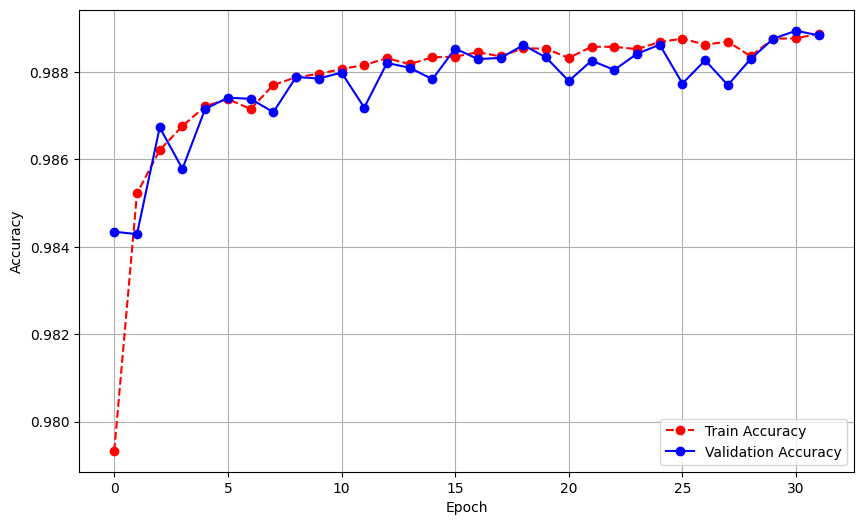

In [2]:
save_graph_tb_log_metrics(
    first_csv_path='C:/Users/b.smadiarov/Downloads/Accuracy_Train.csv',
    second_csv_path='C:/Users/b.smadiarov/Downloads/Accuracy_Validation.csv',
    name_ox='Epoch',
    name_oy='Accuracy',
    pth_save='pics/Acc_Train_Val_32_epoch.png'
)

График сохранён в pics/Loss_Train_Val_32_epoch.png


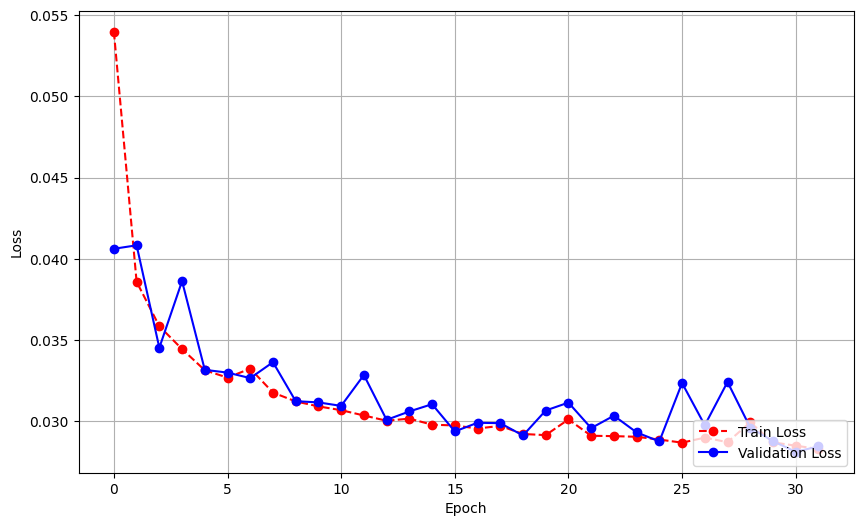

In [3]:
save_graph_tb_log_metrics(
    first_csv_path='C:/Users/b.smadiarov/Downloads/Loss_Train.csv',
    second_csv_path='C:/Users/b.smadiarov/Downloads/Loss_Validation.csv',
    name_ox='Epoch',
    name_oy='Loss',
    pth_save='pics/Loss_Train_Val_32_epoch.png'
)